# Ensemble Learning




In [4]:
#Always include important imports at the top
import numpy as np #for linear algebra functions
import pandas as pd #for data processing the CSV
import time

#visualization
import seaborn as sns 
import matplotlib.pyplot as plt

#sklearn imports
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report #for nice result formatting
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA


#importing a dataset into a dataframe
df = pd.read_csv("taxis.csv").dropna()


## Pre-Processing
Before we can run ensemble learning, we need to pre-process the data and encode labels. We will do this using sklearn's preprocessing package.

In [5]:

df['payment'] = df['payment'].map({'credit card':0, 'cash':1})

In [6]:
#Dropping variables listed above that are correlated
df_final = df.drop(['pickup_zone','dropoff_zone','pickup_borough','dropoff_borough'], axis=1)

#Confirm those variables were sucessfully dropped
df_final

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,0
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,1
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,0
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,0
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,0
...,...,...,...,...,...,...,...,...,...,...
6428,2019-03-31 09:51:53,2019-03-31 09:55:27,1,0.75,4.5,1.06,0.0,6.36,green,0
6429,2019-03-31 17:38:00,2019-03-31 18:34:23,1,18.74,58.0,0.00,0.0,58.80,green,0
6430,2019-03-23 22:55:18,2019-03-23 23:14:25,1,4.14,16.0,0.00,0.0,17.30,green,1
6431,2019-03-04 10:09:25,2019-03-04 10:14:29,1,1.12,6.0,0.00,0.0,6.80,green,0


In [7]:
#Create a function which takes the dataset as input and ouputs the processed dataset
def preprocessor(df):
    res_df = df.copy()
    le = preprocessing.LabelEncoder()
    
    res_df['pickup'] = le.fit_transform(res_df['pickup'])
    res_df['dropoff'] = le.fit_transform(res_df['dropoff'])
    res_df['passengers'] = le.fit_transform(res_df['passengers'])
    res_df['distance'] = le.fit_transform(res_df['distance'])
    res_df['fare'] = le.fit_transform(res_df['fare'])
    res_df['tip'] = le.fit_transform(res_df['tip'])
    res_df['color'] = le.fit_transform(res_df['color'])
    res_df['tolls'] = le.fit_transform(res_df['tolls'])
    res_df['total'] = le.fit_transform(res_df['total'])
    return res_df

#Run the function on the desired dataset
encoded_df = preprocessor(df_final)

The next step is to select which features we want to use with logistic regression and standardize them.

In [8]:
#Selecting features
X = encoded_df.drop(['payment'],axis =1)
y = encoded_df['payment']
y

0       0
1       1
2       0
3       0
4       0
       ..
6428    0
6429    0
6430    1
6431    0
6432    0
Name: payment, Length: 6342, dtype: int64

In [9]:
#Standardizing features
sc = StandardScaler()
X = sc.fit_transform(X)

#Confirm the new mean and standard deviation of the dataset
mean = np.mean(X, axis=0)
print('Mean: (%d, %d)' % (mean[0], mean[1]))
standard_deviation = np.std(X, axis=0)
print('Standard deviation: (%d, %d)' % (standard_deviation[0], standard_deviation[1]))

Mean: (0, 0)
Standard deviation: (1, 1)


## Split into Train and Test data
To apply Sklearn's Random Forest classifier, the data must be split into "training" and "test" data. .

In [10]:
#Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 40)

In [11]:
start = time.time()

#Instantiate the model
rf = RandomForestClassifier(random_state = 1)
#Fit the model with data
rf.fit(X_train, y_train)

end = time.time()
rf_time = end - start
print('Train Time (seconds) of Random Forests without PCA:',rf_time)

y_pred_rf = rf.predict(X_test)

Train Time (seconds) of Random Forests without PCA: 0.9877185821533203


# Performance Analysis
The next step is to conduct a performance analysis of the model. We do this by examining the confusion matrix and the Receiver Operating Characteristic (ROC) curve.

In [12]:
print("Accuracy:", accuracy_score(y_test,y_pred_rf))

Accuracy: 0.9445145018915511


Text(0.5, 257.44, 'Predicted label')

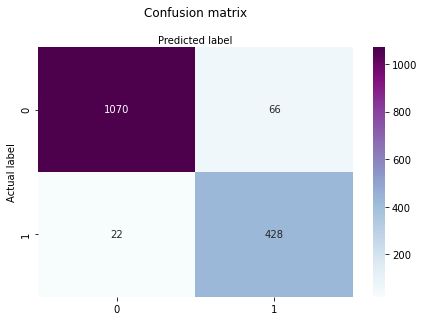

In [13]:
#Creating the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_rf)
class_names=[0,1] # name  of classes

#Creating the figure
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Adding the heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [14]:
#Print a nicely formatted report
classify_rf = classification_report(y_test, y_pred_rf)
print("\nClassification Report")
print(classify_rf)


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1136
           1       0.87      0.95      0.91       450

    accuracy                           0.94      1586
   macro avg       0.92      0.95      0.93      1586
weighted avg       0.95      0.94      0.95      1586



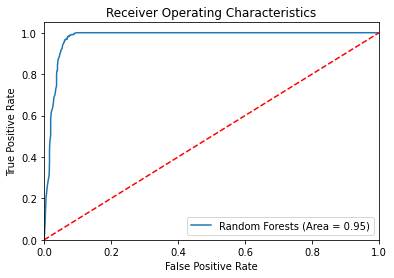

In [15]:
#Plot the ROC curve
rf_roc_auc = roc_auc_score(y_test,y_pred_rf)
fpr, tpr, thresholds = roc_curve(y_test,rf.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Random Forests (Area = %0.2f)' % rf_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Features')

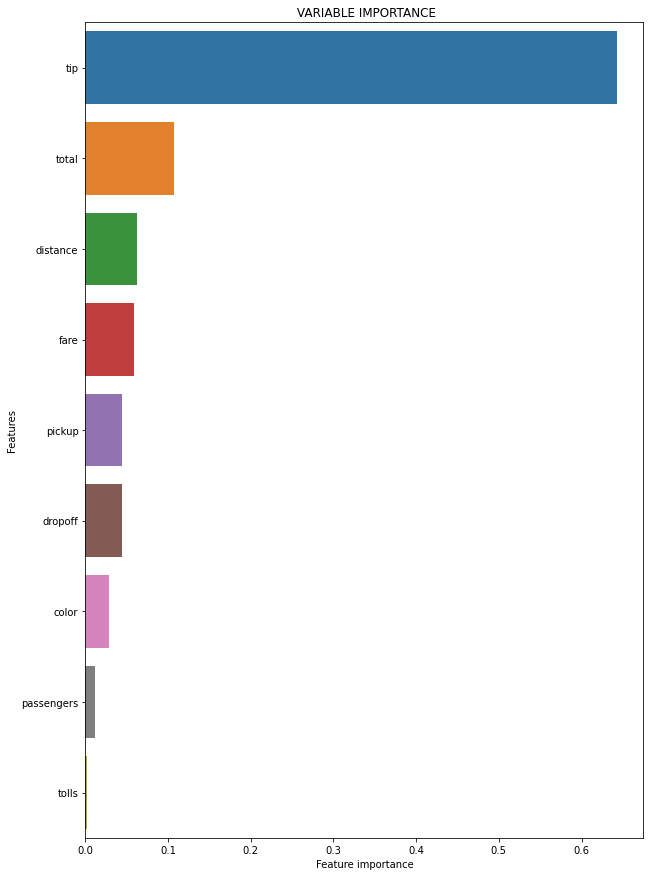

In [16]:
importances = rf.feature_importances_

encoded_df = encoded_df.drop('payment', 1)

feature_imp = np.array(importances)
feature_names= np.array(encoded_df.columns)
data={'feature_names':feature_names,'feature_importance':feature_imp}
table = pd.DataFrame(data) 
table.sort_values(by=['feature_importance'], ascending=False,inplace=True) 
plt.figure(figsize=(10,15))
sns.barplot(x=table['feature_importance'], y=table['feature_names'])
plt.title(' VARIABLE IMPORTANCE')
plt.xlabel('Feature importance')
plt.ylabel('Features')

# Using PCA

In [17]:
# Make an instance of the model and specify that 90% of the variance needs to be retained
n = 90
pca = PCA(n/100)

# Fit the PCA on the training set
pca.fit(X_train)

print('To retain',n,'% of the variation, we needed',pca.n_components_,'components')

To retain 90 % of the variation, we needed 5 components


In [18]:
# Applying transformation to both Training and Test set

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [19]:
start = time.time()

#Instantiate the model
rf_pca = RandomForestClassifier(random_state = 1)
#Fit the model with data
rf_pca.fit(X_train_pca, y_train)

end = time.time()
rf_time_pca = end - start
print('Train Time (seconds) of Random Forests with PCA:',rf_time_pca)

y_pred_rf_pca = rf_pca.predict(X_test_pca)

Train Time (seconds) of Random Forests with PCA: 1.3165085315704346


In [20]:
print("Accuracy:", accuracy_score(y_test,y_pred_rf_pca))

Accuracy: 0.9394703656998739


Text(0.5, 257.44, 'Predicted label')

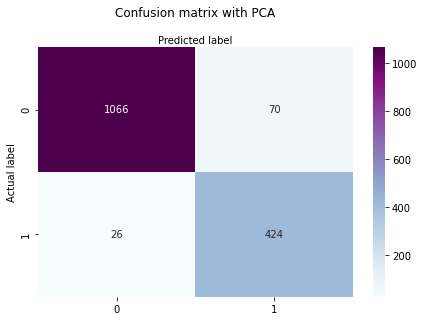

In [24]:
#Creating the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_rf_pca)
class_names=[0,1] # name  of classes

#Creating the figure
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Adding the heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix with PCA', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [22]:
#Print a nicely formatted report
classify_rf = classification_report(y_test, y_pred_rf_pca)
print("\nClassification Report with PCA")
print(classify_rf)


Classification Report with PCA
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1136
           1       0.86      0.94      0.90       450

    accuracy                           0.94      1586
   macro avg       0.92      0.94      0.93      1586
weighted avg       0.94      0.94      0.94      1586



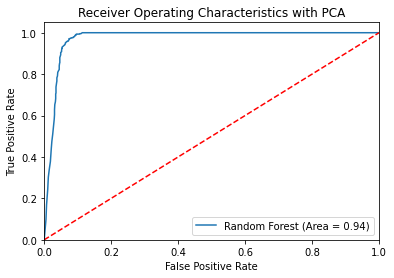

In [23]:
rf_roc_auc_pca = roc_auc_score(y_test,y_pred_rf_pca)
fpr, tpr, thresholds = roc_curve(y_test,rf_pca.predict_proba(X_test_pca)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Random Forest (Area = %0.2f)' % rf_roc_auc_pca)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics with PCA')
plt.legend(loc="lower right")
plt.show()

###  Ensemble Learning:


Training Accuracy: 0.9445145018915511


Test Accuracy: 0.9394703656998739

###  Naive Bayes classifier:


Training accuracy:  0.9325346784363178

Test accuracy score: 0.8953341740226987

### K nearest Neighbours:

Training Root Mean Squared Error: 0.17961998740334567

Testing Root Mean Squared Error: 0.2626910455269232
